<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario de Ciencia de Datos (<i>Data Science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Módulo 10: ejemplo de Policy Gradients en CartPole

En este _notebook_ vamos a ver un ejemplo de implementación de los algoritmos de gradientes de política REINFORCE con línea de base, utilizando el mismo entorno de OpenAI que utilizamos para la DQN para poder comparar mejor los dos métodos.

Tanto para este ejemplo como para las posteriores prácticas se utilizará el <i>framework</i> de __Pytorch__.

## 1. Entorno CartPole

Como en el ejemplo de la DQN, usaremos de nuevo el entorno del juego de **CartPole**, en el que el objetivo es aprender a controlar un objeto. El juego consta de una carretilla y de un palo colocado verticalmente encima de la carretilla. El palo se aguanta únicamente por gravedad, mientras que la carretilla se mueve a derecha y a izquierda sin parar. El objetivo del agente es controlar la velocidad de la carretilla, aumentándola o disminuyéndola con el objetivo de evitar que el palo se caiga. 

### 1.1 Establecer el entorno

En primer lugar, cargaremos la librería __gym__ e inicializaremos el entorno.

In [12]:
import gym

env = gym.envs.make("CartPole-v0")

Cada entorno tiene definido todo lo necesario para que un agente pueda aprender: tenemos un juego que funciona de una manera determinada y nosotros podemos entrenar a un agente para que aprenda a jugar a ese juego sin ninguna otra ayuda que la de experimentar con el juego, observando, actuando y recibiendo recompensas. Así, el entorno del juego ya define qué acciones pueden tomarse, qué estados pueden presentarse, en qué consistirá la recompensa, etc. 

A continuación, podemos visualizar el entorno de __CartPole__ generando un bucle sobre unos pocos episodios y, al terminar, lo cerramos. 

In [13]:
#Visualizar el entorno
for i_episode in range(15):
    observation = env.reset()
    for t in range(100):
        env.render()  #EL RENDER SÓLO FUNCIONA EN LOCAL: comentar línea si no se está en local
        print(observation)
        action = env.action_space.sample() #acción aleatoria
        observation, reward, done, info = env.step(action) #ejecución de la acción elegida
        if done:
            print("Episode finished after {} timesteps".format(t+1)) 
            break
env.close() #cerramos la visualización del entorno

[-0.04520342  0.02139292  0.00510806  0.01598771]
[-0.04477556  0.21644125  0.00542781 -0.2750792 ]
[-4.04467367e-02  4.11485336e-01 -7.37725982e-05 -5.66045254e-01]
[-0.03221703  0.60660832 -0.01139468 -0.85875142]
[-0.02008486  0.80188362 -0.02856971 -1.15499532]
[-0.00404719  0.99736623 -0.05166961 -1.45649792]
[ 0.01590013  0.80291504 -0.08079957 -1.18039451]
[ 0.03195843  0.60892959 -0.10440746 -0.91409489]
[ 0.04413703  0.80529702 -0.12268936 -1.23768211]
[ 0.06024297  0.611946   -0.147443   -0.98581593]
[ 0.07248189  0.80870199 -0.16715932 -1.32093904]
[ 0.08865593  1.00549498 -0.1935781  -1.66093029]
Episode finished after 12 timesteps
[-0.00609054 -0.01663257 -0.03759224 -0.03282528]
[-0.00642319  0.17900774 -0.03824874 -0.33712794]
[-0.00284303 -0.01554963 -0.0449913  -0.05674772]
[-0.00315403 -0.20999857 -0.04612625  0.22140756]
[-0.007354   -0.0142487  -0.0416981  -0.08546126]
[-0.00763897  0.18144539 -0.04340733 -0.39100293]
[-0.00401006 -0.01303449 -0.05122739 -0.11231563

## 2. Construcción del algoritmo de REINFORCE con línea de base

El algoritmo REINFORCE es el principal método de gradientes de política. En el módulo teórico describíamos la generalización del teorema de los gradientes de política como:

$$\nabla J(\theta) \sim \left[\sum^{T-1}_{t=0} \nabla_{\theta}\log \pi_{\theta}(a_t | s_t, \theta)(G_t - b(s_t))\right]$$

donde $\pi_{\theta}$ es la política, $G_t$ el retorno, y $b(s_t)$ la línea de base.

Esta línea de base puede ser **cualquier función o valor aleatorio que sea independiente de la acción** y puede ser estrictamente 0, recuperando así el algoritmo de REINFORCE básico. Añadir una línea de base nos permite reducir de manera significativa la variabilidad debida a posibles grandes diferencias de recompensa entre el primer y el último paso de un mismo episodio.

Así, cada actualización será proporcional al producto del retorno y el gradiente de la probabilidad de tomar la acción acogida, dividido por la probabilidad de tomar esa acción.

$$\theta_{t+1} = \theta + \alpha(G_t-b(S_t))\ln \pi(A_t | S_t, \theta)$$

En este ejemplo usaremos como línea de base el valor de la media de las recompensas de cada episodio.

La construcción del algoritmo se basa en el siguiente proceso (del mismo modo que hicimos con la DQN):

<ol>
    <li> Definir el modelo de red neuronal. </li>
    <li> Definir el agente: cómo debe comportarse. </li>
    <li> Fijar hiperparámetros. </li>
    <li> Entrenar el agente.  </li>
    
</ol>


Empezaremos importando la librería para trabajar en **Pytorch** y en otras necesarias:

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2.1. Definición del modelo

El primer paso es definir nuestra red neuronal. Para este ejemplo usaremos una red neuronal muy sencilla con dos capas lineales (una capa ReLU y una de salida Softmax) y el optimizador Adam.

También indicaremos la opción de poder trabajar con **CPU** o **CUDA** por si se tiene la opción, puesto que en aprendizaje por refuerzo la mayoría de los procesos suelen requerir mucha máquina y la aceleración por hardware es usualmente necesaria. **Este ejemplo se puede ejecutar con CPU**.


In [15]:
class PGReinforce(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(PGReinforce, self).__init__()
        self.device=device
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.learning_rate = learning_rate
        
        ### Construcción de la red neuronal
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 16), 
            torch.nn.ReLU(), 
            torch.nn.Linear(16, self.n_outputs),
            torch.nn.Softmax(dim=-1))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        
        ### Se ofrece la opción de trabajar con cuda
        if self.device == 'cuda':
            self.model.cuda()

    #Obtención de las probabilidades de las posibles acciones       
    def get_action_prob(self, state):
        action_probs = self.model(torch.FloatTensor(state))
        return action_probs

### 2.2. Definición del agente

Una vez que tenemos el modelo definido, solo nos queda definir el comportamiento del agente, cómo aprende.

Como se explica en el texto teórico, en este caso, **no** necesitamos incluir ningún método de exploración-explotación, ni un *buffer* de repetición de experiencias, ni una red objetivo, como sí ocurre con las DQN, dado que:

<ol>
    <li> Exploración: se realiza automáticamente gracias a que la red devuelve una distribución uniforme de probabilidad de las posibles acciones, por lo que el comportamiento aleatorio al principio del proceso ya está considerado. </li>
    <li> <i>Buffer</i>: no hay necesidad porque no podemos entrenar con los datos obtenidos de la política anterior, ya que el agente se orienta por la política, no por los valores obtenidos de sus acciones.</li>
    <li> Red objetivo: la utilizábamos para romper la correlación en el cálculo de los valores <i>Q</i>, pero en los PG no calculamos ningún valor de <i>Q</i>. </li>
    
</ol>

El proceso del agente se ciñe, pues, en elegir acciones según su probabilidad, actualizar la red según la ecuación anterior y calcular la pérdida. Este proceso se repite hasta que el agente consiga la recompensa objetivo a partir de la cual se considera que ha aprendido a jugar (en **CartPole** es 195, como se indica en la variable `env.spec.reward_threshold`) o hasta que se agote el límite máximo de episodios establecido (hiperparámetro fijado).


In [16]:
class reinforceAgent:
        
    def __init__(self, env, pgnetwork):
        
        self.env = env
        self.pgnetwork = pgnetwork
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensa
        self.reward_threshold = self.env.spec.reward_threshold # recompensa media a partir de la cual se considera
                                                               # que el agente ha aprendido a jugar
        self.initialize()
        
        
    def initialize(self):
        self.batch_rewards = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_counter = 1
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_loss = []
        
        
    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size
        
        episode = 0
        action_space = np.arange(self.env.action_space.n)
        training = True
        print("Training...")
        while training:
            state0 = env.reset()
            episode_states = []
            episode_rewards = []
            episode_actions = []
            gamedone = False
            
            while gamedone == False:
                # Obtenemos las acciones
                action_probs = self.pgnetwork.get_action_prob(state0).detach().numpy()
                action = np.random.choice(action_space, p=action_probs)
                next_state, reward, gamedone, _ = env.step(action)
                
                # Almacenamos las experiencias que se van obteniendo en este episodio
                episode_states.append(state0)
                episode_rewards.append(reward)
                episode_actions.append(action)
                state0 = next_state
                
                
                if gamedone:
                    episode += 1
                    # Calculamos el término del retorno menos la línea de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    self.training_rewards.append(sum(episode_rewards)) # guardamos las recompensas obtenidas
                    
                    
                    # Actualizamos la red cuando se completa el tamaño del batch
                    if self.batch_counter == self.batch_size:
                        self.update(self.batch_states, self.batch_rewards, self.batch_actions)
                        self.update_loss = []
                    
                        # Reseteamos las variables del epsiodio
                        self.batch_rewards = []
                        self.batch_actions = []
                        self.batch_states = []
                        self.batch_counter = 1
                    
                    #Actualizamos el contador del batch
                    self.batch_counter += 1
                    
                    # Calculamos la media de recompensa de los últimos X episodios
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f}\t\t".format(
                        episode, mean_rewards), end="")
                    
                    # Comprobamos que todavía quedan episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                        

    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):  #revertimos la dirección del vector para hacer la suma cumulativa
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        baseline = np.mean(discount_r) # establecemos la media de la recompensa como línea de base
        return discount_r - baseline 
    
    
    ## Actualización                
    def update(self, batch_s, batch_r, batch_a):
        self.pgnetwork.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)       
        action_t = torch.LongTensor(batch_a)             
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.pgnetwork.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.pgnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())
        
        
    ## Cálculo de la pérdida
    # Recordatorio: cada actualización es proporcional al producto del retorno y el gradiente de la probabilidad
    # de tomar la acción tomada, dividido por la probabilidad de tomar esa acción (logaritmo natural)
    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.pgnetwork.get_action_prob(state_t))
        selected_logprobs = reward_t * \
                        logprob[np.arange(len(action_t)), action_t]
        loss = -selected_logprobs.mean()
        return loss
   

    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

### 2.3. Hiperparámetros

Fijamos los hiperparámetros necesarios:

In [17]:
lr = 0.01            #Velocidad aprendizaje
MAX_EPISODES = 5000  #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
GAMMA = 0.99
BATCH_SIZE = 10

### 2.4. Entrenamiento

Cargamos el modelo de red neuronal:

In [18]:
pgR = PGReinforce(env, learning_rate=lr)

Creamos nuestro agente:

In [19]:
agent = reinforceAgent(env, pgR)

Entrenamos el agente con los hiperparámetros establecidos:

In [20]:
agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE)

Training...
Episode 838 Mean Rewards 195.00		
Environment solved in 838 episodes!


### 2.5. Representar aprendizaje del agente

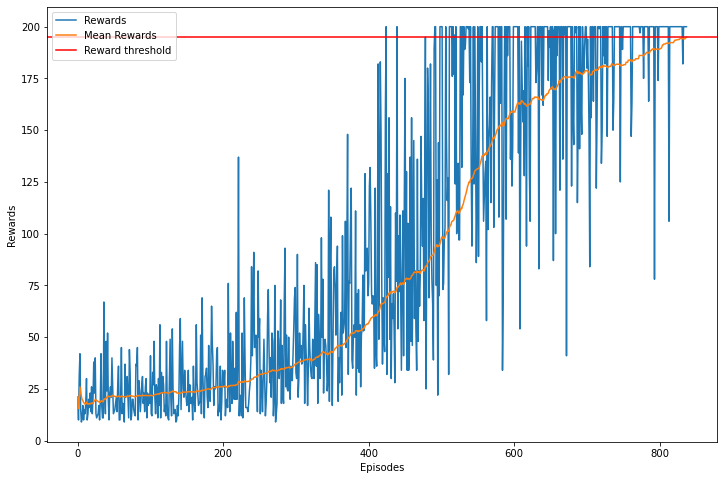

In [21]:
agent.plot_rewards()